In [2]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm


# We first define how the model will view a face, i.e. how to encode a face in
# a tensor
def face_to_tensor(face):
    return torch.tensor([i in face for i in sorted_keys]).float()


class FlowModel(nn.Module):
    def __init__(self, num_hid):
        super().__init__()
        # We encoded the current state as binary vector, for each patch the associated
        # dimension is either 0 or 1 depending on the absence or precense of that patch.
        # Therefore the input dimension is 6 for the 6 patches.
        self.mlp = nn.Sequential(
            nn.Linear(6, num_hid),
            nn.LeakyReLU(),
            # We also output 6 numbers, since there are up to
            # 6 possible actions (and thus child states), but we
            # will mask those outputs for patches that are
            # already there.
            nn.Linear(num_hid, 6),
        )

    def forward(self, x):
        # We take the exponential to get positive numbers, since flows must be positive,
        # and multiply by (1 - x) to give 0 flow to actions we know we can't take
        # (in this case, x[i] is 1 if a feature is already there, so we know we
        # can't add it again).
        F = self.mlp(x).exp() * (1 - x)
        return F

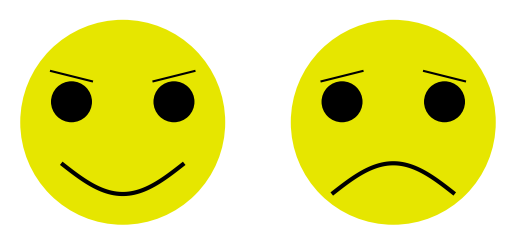

In [3]:
import matplotlib.pyplot as pp
import numpy as np

base_face = lambda: (
    pp.gca().add_patch(pp.Circle((0.5, 0.5), 0.5, fc=(0.9, 0.9, 0))),
    pp.gca().add_patch(pp.Circle((0.25, 0.6), 0.1, fc=(0, 0, 0))),
    pp.gca().add_patch(pp.Circle((0.75, 0.6), 0.1, fc=(0, 0, 0))),
)
patches = {
    "smile": lambda: pp.gca().add_patch(
        pp.Polygon(
            np.stack(
                [np.linspace(0.2, 0.8), 0.3 - np.sin(np.linspace(0, 3.14)) * 0.15]
            ).T,
            closed=False,
            fill=False,
            lw=3,
        )
    ),
    "frown": lambda: pp.gca().add_patch(
        pp.Polygon(
            np.stack(
                [np.linspace(0.2, 0.8), 0.15 + np.sin(np.linspace(0, 3.14)) * 0.15]
            ).T,
            closed=False,
            fill=False,
            lw=3,
        )
    ),
    "left_eb_down": lambda: pp.gca().add_line(
        pp.Line2D([0.15, 0.35], [0.75, 0.7], color=(0, 0, 0))
    ),
    "right_eb_down": lambda: pp.gca().add_line(
        pp.Line2D([0.65, 0.85], [0.7, 0.75], color=(0, 0, 0))
    ),
    "left_eb_up": lambda: pp.gca().add_line(
        pp.Line2D([0.15, 0.35], [0.7, 0.75], color=(0, 0, 0))
    ),
    "right_eb_up": lambda: pp.gca().add_line(
        pp.Line2D([0.65, 0.85], [0.75, 0.7], color=(0, 0, 0))
    ),
}
sorted_keys = sorted(patches.keys())


def draw_face(face):
    base_face()
    for i in face:
        patches[i]()
    pp.axis("scaled")
    pp.axis("off")


f, ax = pp.subplots(1, 2)
pp.sca(ax[0])
draw_face(["smile", "left_eb_down", "right_eb_down"])
pp.sca(ax[1])
draw_face(["frown", "left_eb_up", "right_eb_up"])

In [4]:
def has_overlap(face):
    # Can't have two overlapping eyebrows!
    if "left_eb_down" in face and "left_eb_up" in face:
        return True
    if "right_eb_down" in face and "right_eb_up" in face:
        return True
    # Can't have two overlapping mouths!
    if "smile" in face and "frown" in face:
        return True
    return False


def face_reward(face):
    if has_overlap(face):
        return 0
    eyebrows = "left_eb_down", "left_eb_up", "right_eb_down", "right_eb_up"
    # Must have exactly two eyebrows
    if sum([i in face for i in eyebrows]) != 2:
        return 0
    # We want twice as many happy faces as sad faces so here we give a reward of 2 for smiles
    if "smile" in face:
        return 2
    if "frown" in face:
        return 1  # and a reward of 1 for frowns
    # If we reach this point, there's no mouth
    return 0


def face_parents(state):
    parent_states = []  # states that are parents of state
    parent_actions = []  # actions that lead from those parents to state
    for face_part in state:
        # For each face part, there is a parent without that part
        parent_states.append([i for i in state if i != face_part])
        # The action to get there is the corresponding index of that face part
        parent_actions.append(sorted_keys.index(face_part))
    return parent_states, parent_actions

In [5]:
# Instantiate model and optimizer
F_sa = FlowModel(512)
opt = torch.optim.Adam(F_sa.parameters(), 3e-4)

# Let's keep track of the losses and the faces we sample
losses = []
sampled_faces = []
# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 4
for episode in tqdm.tqdm(range(50000), ncols=40):
    # Each episode starts with an "empty state"
    state = []
    # Predict F(s, a)
    edge_flow_prediction = F_sa(face_to_tensor(state))
    for t in range(3):
        # The policy is just normalizing, and gives us the probability of each action
        policy = edge_flow_prediction / edge_flow_prediction.sum()
        # Sample the action
        action = Categorical(probs=policy).sample()
        # "Go" to the next state
        new_state = state + [sorted_keys[action]]

        # Now we want to compute the loss, we'll first enumerate the parents
        parent_states, parent_actions = face_parents(new_state)
        # And compute the edge flows F(s, a) of each parent
        px = torch.stack([face_to_tensor(p) for p in parent_states])
        pa = torch.tensor(parent_actions).long()
        parent_edge_flow_preds = F_sa(px)[torch.arange(len(parent_states)), pa]
        # Now we need to compute the reward and F(s, a) of the current state,
        # which is currently `new_state`
        if t == 2:
            # If we've built a complete face, we're done, so the reward is > 0
            # (unless the face is invalid)
            reward = face_reward(new_state)
            # and since there are no children to this state F(s,a) = 0 \forall a
            edge_flow_prediction = torch.zeros(6)
        else:
            # Otherwise we keep going, and compute F(s, a)
            reward = 0
            edge_flow_prediction = F_sa(face_to_tensor(new_state))

        # The loss as per the equation above
        flow_mismatch = (
            parent_edge_flow_preds.sum() - edge_flow_prediction.sum() - reward
        ).pow(2)
        minibatch_loss += flow_mismatch  # Accumulate
        # Continue iterating
        state = new_state

    # We're done with the episode, add the face to the list, and if we are at an
    # update episode, take a gradient step.
    sampled_faces.append(state)
    if episode % update_freq == 0:
        losses.append(minibatch_loss.item())
        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss = 0

  1%| | 504/50000 [00:01<02:09, 380.98it


KeyboardInterrupt: 

In [12]:
minibatch_loss.item()

8.756658554077148

In [11]:
minibatch_loss

tensor(8.7567, grad_fn=<AddBackward0>)

In [7]:
F_sa(px)

tensor([[0.1828, 0.1892, 0.1749, 0.2336, 0.0000, 0.0000],
        [0.1814, 0.0000, 0.1888, 0.2259, 0.0000, 0.2696],
        [0.2221, 0.0000, 0.1855, 0.2404, 0.1961, 0.0000]],
       grad_fn=<MulBackward0>)

In [10]:
parent_edge_flow_preds

tensor([0.1892, 0.2696, 0.1961], grad_fn=<IndexBackward0>)

In [8]:
[torch.arange(len(parent_states)), pa]

[tensor([0, 1, 2]), tensor([1, 5, 4])]

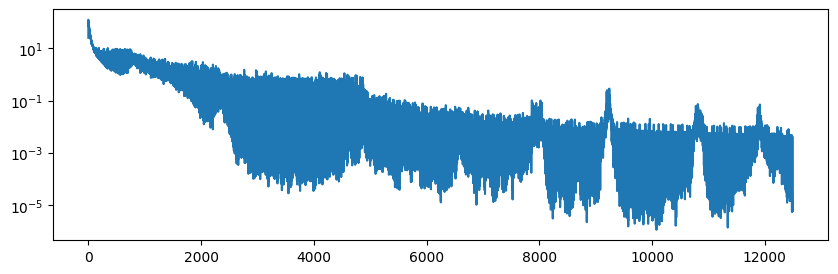

In [6]:
pp.figure(figsize=(10, 3))
pp.plot(losses)
pp.yscale("log")

Ratio of faces with a smile: 0.609375
Ratio of valid faces: 0.9609375


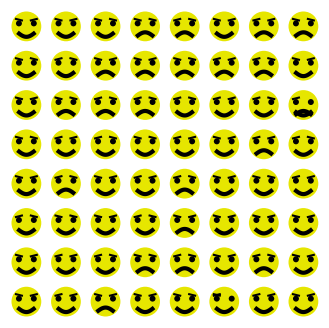

In [7]:
f, ax = pp.subplots(8, 8, figsize=(4, 4))
print(
    "Ratio of faces with a smile:",
    sum(["smile" in i for i in sampled_faces[-128:]]) / 128,
)
print(
    "Ratio of valid faces:",
    sum([face_reward(i) > 0 for i in sampled_faces[-128:]]) / 128,
)
for i, face in enumerate(sampled_faces[-64:]):
    pp.sca(ax[i // 8, i % 8])
    draw_face(face)

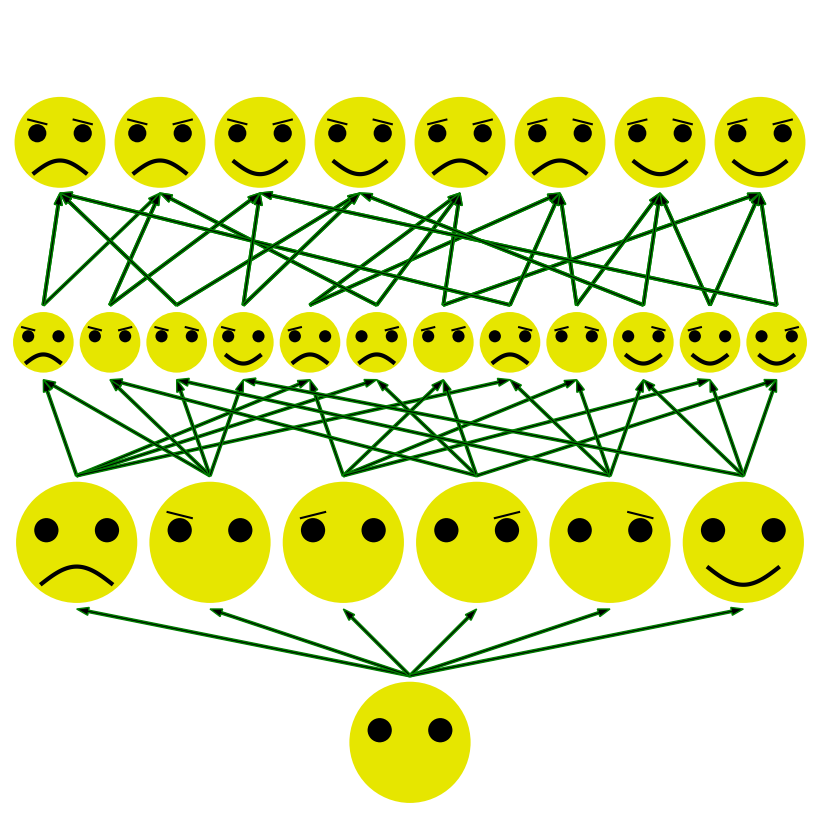

In [9]:
# @title
enumerated_states = []
transitions = []


def recursively_enumerate(s):
    if has_overlap(s):
        return
    for i in sorted_keys:
        if i not in s:
            recursively_enumerate(s + [i])
    enumerated_states.append(s)
    transitions.append((s[:-1], s))


recursively_enumerate([])
unique = []
for i in map(set, enumerated_states):
    if i not in unique:
        unique.append(i)
enumerated_states = sorted(map(tuple, unique))

lens = [len([i for i in enumerated_states if len(i) == j]) for j in range(4)]
levels = [sorted([i for i in enumerated_states if len(i) == j]) for j in range(4)]
f = pp.figure(figsize=(8, 8))


def face_hash(face):
    return tuple([i in face for i in sorted_keys])


face2pos = {}
for i, (level, L) in enumerate(zip(levels, lens)):
    for j, face in enumerate(level):
        ax = f.add_axes([j / L, i / 4, 1 / L, 1 / 6])
        draw_face(face)
        face2pos[face_hash(face)] = (j / L + 0.5 / L, i / 4)
ax = f.add_axes([0, 0, 1, 1])
pp.sca(ax)
pp.gca().set_facecolor((0, 0, 0, 0))
pp.xlim(0, 1)
pp.ylim(0, 1)
for a, b in transitions[1:]:
    pa, pb = face2pos[face_hash(a)], face2pos[face_hash(b)]
    if not len(b):
        continue
    lb = int(pb[1] * 4)
    la = int(pa[1] * 4)
    ws = [1 / 6, 1 / 6, 0.13, 0.11]
    pp.arrow(
        pa[0],
        pa[1] + ws[la],
        pb[0] - pa[0],
        pb[1] - pa[1] - ws[lb],
        head_width=0.01,
        width=0.003,
        ec=(0.0, 0.5, 0),
        fc=(0, 0, 0),
        length_includes_head=True,
    )
    pp.axis("off")

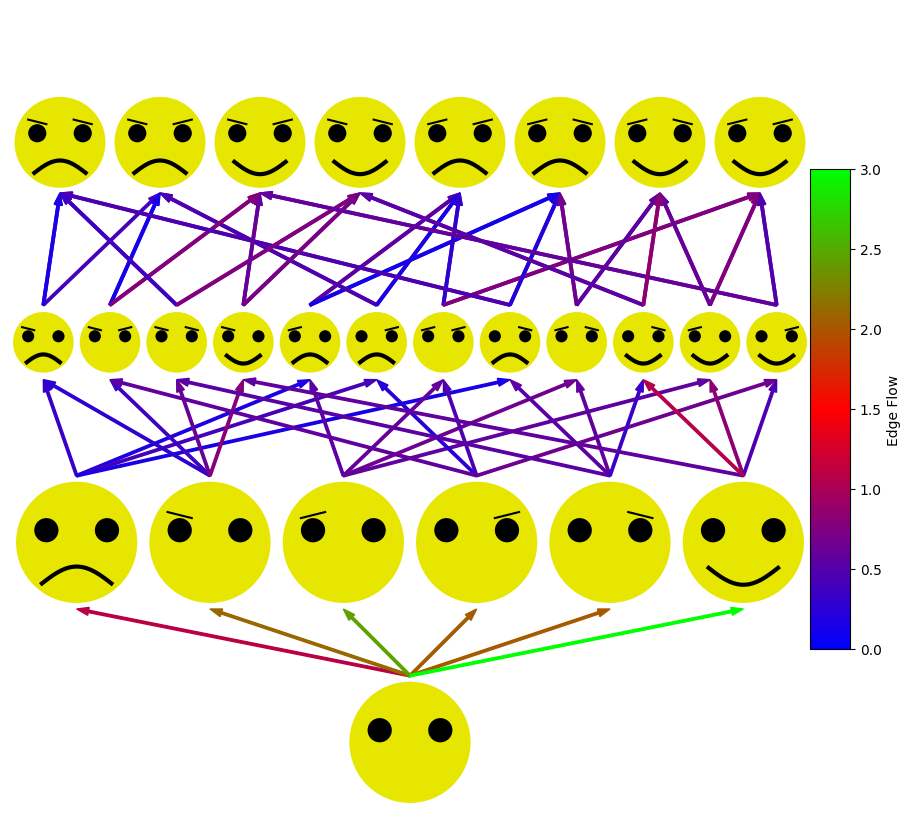

In [10]:
# @title
import matplotlib.cm as cm

lens = [len([i for i in enumerated_states if len(i) == j]) for j in range(4)]
levels = [sorted([i for i in enumerated_states if len(i) == j]) for j in range(4)]
f = pp.figure(figsize=(8, 8))


def face_hash(face):
    return tuple([i in face for i in sorted_keys])


face2pos = {}
for i, (level, L) in enumerate(zip(levels, lens)):
    for j, face in enumerate(level):
        ax = f.add_axes([j / L, i / 4, 1 / L, 1 / 6])
        draw_face(face)
        face2pos[face_hash(face)] = (j / L + 0.5 / L, i / 4)
        Fstate = F_sa(torch.tensor(face_hash(face)).float())
        # print(face, Fstate.data)
ax = f.add_axes([0, 0, 1, 1])
pp.sca(ax)
pp.gca().set_facecolor((0, 0, 0, 0))
pp.xlim(0, 1)
pp.ylim(0, 1)
for a, b in transitions[1:]:
    if not len(b):
        continue
    pa, pb = face2pos[face_hash(a)], face2pos[face_hash(b)]
    lb = int(pb[1] * 4)
    Fstate = F_sa(torch.tensor(face_hash(a)).float())
    Fa = Fstate[sorted_keys.index([i for i in b if i not in a][0])].item()
    c = cm.brg(Fa / 3)
    lb = int(pb[1] * 4)
    la = int(pa[1] * 4)
    ws = [1 / 6, 1 / 6, 0.13, 0.11]
    pp.arrow(
        pa[0],
        pa[1] + ws[la],
        pb[0] - pa[0],
        pb[1] - pa[1] - ws[lb],
        head_width=0.01,
        width=0.003,
        ec=c,
        fc=c,
        length_includes_head=True,
    )
    pp.axis("off")
ax = f.add_axes([1, 0.2, 0.05, 0.6])
pp.sca(ax)
f.colorbar(
    cm.ScalarMappable(norm=cm.colors.Normalize(vmin=0, vmax=3), cmap=cm.brg),
    cax=ax,
    label="Edge Flow",
)

In [11]:
F_sa(face_to_tensor([])).sum()

tensor(12.7199, grad_fn=<SumBackward0>)

In [12]:
class TBModel(nn.Module):
    def __init__(self, num_hid):
        super().__init__()
        # The input dimension is 6 for the 6 patches.
        self.mlp = nn.Sequential(
            nn.Linear(6, num_hid),
            nn.LeakyReLU(),
            # We now output 12 numbers, 6 for P_F and 6 for P_B
            nn.Linear(num_hid, 12),
        )
        # log Z is just a single number
        self.logZ = nn.Parameter(torch.ones(1))

    def forward(self, x):
        logits = self.mlp(x)
        # Slice the logits, and mask invalid actions (since we're predicting
        # log-values), we use -100 since exp(-100) is tiny, but we don't want -inf)
        P_F = logits[..., :6] * (1 - x) + x * -100
        P_B = logits[..., 6:] * x + (1 - x) * -100
        return P_F, P_B

In [13]:
# Instantiate model and optimizer
model = TBModel(512)
opt = torch.optim.Adam(model.parameters(), 3e-4)

# Let's keep track of the losses and the faces we sample
tb_losses = []
tb_sampled_faces = []
# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 2

logZs = []
for episode in tqdm.tqdm(range(50000), ncols=40):
    # Each episode starts with an "empty state"
    state = []
    # Predict P_F, P_B
    P_F_s, P_B_s = model(face_to_tensor(state))
    total_P_F = 0
    total_P_B = 0
    for t in range(3):
        # Here P_F is logits, so we want the Categorical to compute the softmax for us
        cat = Categorical(logits=P_F_s)
        action = cat.sample()
        # "Go" to the next state
        new_state = state + [sorted_keys[action]]
        # Accumulate the P_F sum
        total_P_F += cat.log_prob(action)

        if t == 2:
            # If we've built a complete face, we're done, so the reward is > 0
            # (unless the face is invalid)
            reward = torch.tensor(face_reward(new_state)).float()
        # We recompute P_F and P_B for new_state
        P_F_s, P_B_s = model(face_to_tensor(new_state))
        # Here we accumulate P_B, going backwards from `new_state`. We're also just
        # going to use opposite semantics for the backward policy. I.e., for P_F action
        # `i` just added the face part `i`, for P_B we'll assume action `i` removes
        # face part `i`, this way we can just keep the same indices.
        total_P_B += Categorical(logits=P_B_s).log_prob(action)

        # Continue iterating
        state = new_state

    # We're done with the trajectory, let's compute its loss. Since the reward can
    # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
    loss = (model.logZ + total_P_F - torch.log(reward).clip(-20) - total_P_B).pow(2)
    minibatch_loss += loss

    # Add the face to the list, and if we are at an
    # update episode, take a gradient step.
    tb_sampled_faces.append(state)
    if episode % update_freq == 0:
        tb_losses.append(minibatch_loss.item())
        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss = 0
        logZs.append(model.logZ.item())

100%|█| 50000/50000 [02:56<00:00, 283.16


In [14]:
model.logZ.exp()

tensor([11.7415], grad_fn=<ExpBackward0>)

Text(0, 0.5, 'estimated Z')

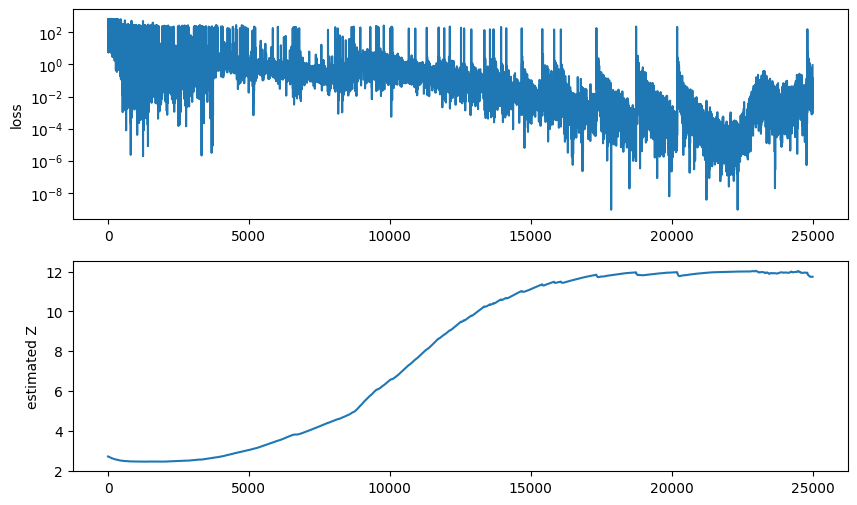

In [15]:
f, ax = pp.subplots(2, 1, figsize=(10, 6))
pp.sca(ax[0])
pp.plot(tb_losses)
pp.yscale("log")
pp.ylabel("loss")
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel("estimated Z")

Ratio of faces with a smile: 0.6171875
Ratio of valid faces: 1.0


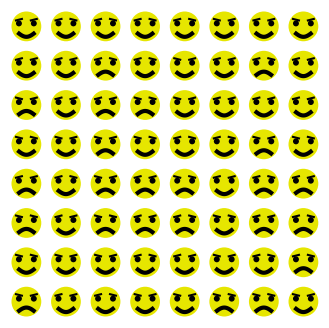

In [16]:
f, ax = pp.subplots(8, 8, figsize=(4, 4))
print(
    "Ratio of faces with a smile:",
    sum(["smile" in i for i in tb_sampled_faces[-128:]]) / 128,
)
print(
    "Ratio of valid faces:",
    sum([face_reward(i) > 0 for i in tb_sampled_faces[-128:]]) / 128,
)
for i, face in enumerate(tb_sampled_faces[-64:]):
    pp.sca(ax[i // 8, i % 8])
    draw_face(face)